In [1]:
import pandas as pd

import os

os.environ["OMP_NUM_THREADS"] = "2"
os.environ["OPENBLAS_NUM_THREADS"] = "2"
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["VECLIB_MAXIMUM_THREADS"] = "2"
os.environ["NUMEXPR_NUM_THREADS"] = "2"



import pandas as pd

# Load and combine datasets (as before)
datasets = {
    'benign': pd.read_csv('labeled_dataset_benign.csv'),
    'dns': pd.read_csv('labeled_dataset_DNS_spoofing.csv'),
    'mitm': pd.read_csv('labeled_dataset_MITM_ArpSpoofing.csv')
}
combined_df = pd.concat([datasets['benign'], datasets['dns'], datasets['mitm']], ignore_index=True)
combined_df = combined_df.drop('dst_mac', axis=1)

print(combined_df.shape)

C:\Users\nazih\AppData\Local\Temp\ipykernel_18640\3635347684.py:18: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  'dns': pd.read_csv('labeled_dataset_DNS_spoofing.csv'),
C:\Users\nazih\AppData\Local\Temp\ipykernel_18640\3635347684.py:19: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  'mitm': pd.read_csv('labeled_dataset_MITM_ArpSpoofing.csv')


(883525, 135)


In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

def is_hex_mac(mac):
    if pd.isna(mac) or mac == 'unknown':
        return False
    pattern = r'^([0-9A-Fa-f]{2}[:-]){5}([0-9A-Fa-f]{2})$'
    return bool(re.match(pattern, str(mac)))


combined_df = combined_df[~combined_df['src_mac'].apply(is_hex_mac)]

# Drop duplicates
print(f"Number of duplicate rows: {combined_df.duplicated().sum()}")
combined_df = combined_df.drop_duplicates()
print(f"New shape after removing duplicates: {combined_df.shape}")

# Identify categorical columns
categorical_cols = [col for col in combined_df.columns if combined_df[col].nunique() < 10 or combined_df[col].dtype == 'object']
print(f"Categorical features: {categorical_cols}")

for col in categorical_cols:
    combined_df[col] = combined_df[col].astype(str).fillna('unknown')

numerical_cols = combined_df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    combined_df[col] = combined_df[col].fillna(combined_df[col].median())

X = combined_df.drop(['Label', 'src_mac'], axis=1, errors='ignore')
y_attack = combined_df['Label']
y_device = combined_df['src_mac']

# Encode device labels
le_device = LabelEncoder()
y_device_encoded = le_device.fit_transform(y_device)

from sklearn.preprocessing import MultiLabelBinarizer


combined_df['All_Labels'] = combined_df.apply(
    lambda row: [row['Label'], row['src_mac']], axis=1
)

mlb = MultiLabelBinarizer()
Y_multilabel = mlb.fit_transform(combined_df['All_Labels'])

multilabel_class_names = mlb.classes_


X_numeric = X.select_dtypes(include=['number'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)




X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled,
    Y_multilabel,
    test_size=0.2,
    random_state=42
)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)



Number of duplicate rows: 0
New shape after removing duplicates: (432555, 135)
Categorical features: ['src_mac', 'src_ip', 'dst_ip', 'port_class_dst', 'l4_tcp', 'l4_udp', 'ttl', 'handshake_version', 'handshake_ciphersuites', 'tls_server', 'http_request_method', 'http_host', 'http_response_code', 'user_agent', 'dns_server', 'dns_query_type', 'dns_len_ans', 'device_mac', 'eth_src_oui', 'eth_dst_oui', 'highest_layer', 'http_uri', 'http_content_len', 'http_content_type', 'icmp_type', 'icmp_checksum_status', 'icmp_data_size', 'Label']


C:\Users\nazih\AppData\Local\Temp\ipykernel_18640\1952102281.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df['All_Labels'] = combined_df.apply(


In [3]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, jaccard_score, classification_report
from sklearn.base import clone

xgb_rfe_estimator = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)


TARGET_FEATURES = 50
rfe_selector = RFE(
    estimator=xgb_rfe_estimator,
    n_features_to_select=TARGET_FEATURES,
    step=5,
    verbose=1
)

print(f"Starting RFE to select {TARGET_FEATURES} features...")
Y_single_label = Y_train[:, 0]
rfe_selector.fit(X_train, Y_single_label)


selected_features = X_train.columns[rfe_selector.support_]

X_train_RFE = X_train[selected_features]
X_test_RFE = X_test[selected_features]

print(f"RFE complete. Using {len(selected_features)} features.")
print(f"Selected features: {selected_features.tolist()[:5]}... (first 5 shown)")


try:
    multilabel_class_names = mlb.classes_
except NameError:
    multilabel_class_names = [f"Label_{i+1}" for i in range(Y_train.shape[1])]


print("\n--- Training Multi-Label XGBoost (Weighted) on RFE Features ---")

xgb_base = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss',
    n_jobs=1,
    max_depth=8,
    reg_alpha=0.5,
    reg_lambda=3
)

num_outputs = Y_train.shape[1]
fitted_xgb_estimators = []

print("Fitting individual XGBoost models with custom scale_pos_weight...")

for i in range(num_outputs):
    y_col = Y_train[:, i]

    pos_count = np.sum(y_col == 1)
    neg_count = np.sum(y_col == 0)
    weight = neg_count / pos_count if pos_count > 0 else 1.0

    xgb_estimator = clone(xgb_base).set_params(scale_pos_weight=weight)

    xgb_estimator.fit(X_train_RFE, y_col)

    fitted_xgb_estimators.append(xgb_estimator)

Y_pred_xgb = np.zeros_like(Y_test)

for i, estimator in enumerate(fitted_xgb_estimators):
    Y_pred_xgb[:, i] = estimator.predict(X_test_RFE)


subset_acc = accuracy_score(Y_test, Y_pred_xgb)
jaccard = jaccard_score(Y_test, Y_pred_xgb, average='samples', zero_division=0)

print("FINAL WEIGHTED XGBOOST (RFE FEATURES) TEST SET RESULTS")
print("="*70)
print(f"Subset Accuracy (Exact Match): {subset_acc:.4f}")
print(f"Jaccard Score (Label Similarity): {jaccard:.4f}")

print("MULTI-LABEL CLASSIFICATION REPORT")

report = classification_report(
    Y_test,
    Y_pred_xgb,
    target_names=multilabel_class_names,
    zero_division=0,
    output_dict=False
)
print(report)

Starting RFE to select 50 features...
Fitting estimator with 107 features.
Fitting estimator with 102 features.
Fitting estimator with 97 features.
Fitting estimator with 92 features.
Fitting estimator with 87 features.
Fitting estimator with 82 features.
Fitting estimator with 77 features.
Fitting estimator with 72 features.
Fitting estimator with 67 features.
Fitting estimator with 62 features.
Fitting estimator with 57 features.
Fitting estimator with 52 features.
RFE complete. Using 50 features.
Selected features: [0, 1, 2, 3, 6]... (first 5 shown)

--- Training Multi-Label XGBoost (Weighted) on RFE Features ---
Fitting individual XGBoost models with custom scale_pos_weight...
FINAL WEIGHTED XGBOOST (RFE FEATURES) TEST SET RESULTS
Subset Accuracy (Exact Match): 0.9771
Jaccard Score (Label Similarity): 0.9870
MULTI-LABEL CLASSIFICATION REPORT
                                            precision    recall  f1-score   support

                       AMCREST WiFi Camera       0.93    


--- AGGREGATE MULTI-LABEL CONFUSION MATRIX ---
[[5102496    1653]
 [   1614  171408]]


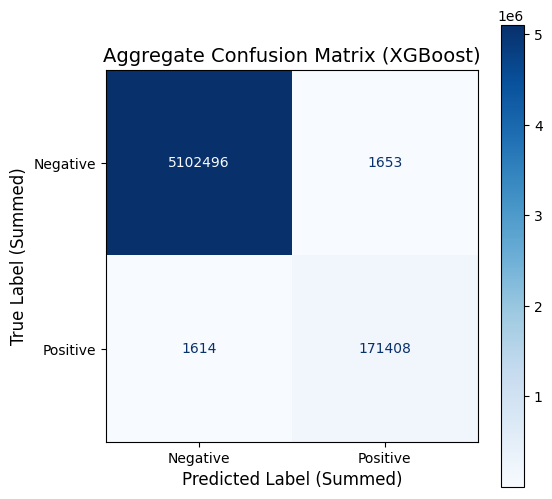


Aggregate CM Statistics (Total Label-Predictions):
Total True Positives (TP): 171408
Total True Negatives (TN): 5102496
Total False Positives (FP): 1653
Total False Negatives (FN): 1614
Total Binary Predictions Made: 5277171 (86511 samples * 61 labels)


In [4]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

all_label_cms = multilabel_confusion_matrix(Y_test, Y_pred_xgb)


aggregate_cm = np.sum(all_label_cms, axis=0)


print("\n--- AGGREGATE MULTI-LABEL CONFUSION MATRIX ---")
print(aggregate_cm)

cm_display = ConfusionMatrixDisplay(
    confusion_matrix=aggregate_cm,
    display_labels=['Negative', 'Positive']
)

fig, ax = plt.subplots(figsize=(6, 6))

cm_display.plot(cmap='Blues', ax=ax, values_format='d')

ax.set_title('Aggregate Confusion Matrix (XGBoost)', fontsize=14)
ax.set_xlabel('Predicted Label (Summed)', fontsize=12)
ax.set_ylabel('True Label (Summed)', fontsize=12)

plt.show()

TN = aggregate_cm[0, 0]
FP = aggregate_cm[0, 1]
FN = aggregate_cm[1, 0]
TP = aggregate_cm[1, 1]

total_predictions = TN + FP + FN + TP
num_samples = Y_test.shape[0]
num_labels = Y_test.shape[1]

print("\nAggregate CM Statistics (Total Label-Predictions):")
print(f"Total True Positives (TP): {TP}")
print(f"Total True Negatives (TN): {TN}")
print(f"Total False Positives (FP): {FP}")
print(f"Total False Negatives (FN): {FN}")
print(f"Total Binary Predictions Made: {total_predictions} ({num_samples} samples * {num_labels} labels)")

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

MODEL_NAME = 'RandomForest'
rf_base_estimator = RandomForestClassifier(
    n_estimators=50,
    random_state=42,
    class_weight='balanced'

)

print(f"\n--- Training {MODEL_NAME} (Parallel Fit via MultiOutputClassifier) ---")

multi_model_rf = MultiOutputClassifier(rf_base_estimator, n_jobs=-1)

multi_model_rf.fit(X_train_RFE, Y_train)

Y_pred_rf = multi_model_rf.predict(X_test_RFE)

subset_acc = accuracy_score(Y_test, Y_pred_rf)
jaccard = jaccard_score(Y_test, Y_pred_rf, average='samples', zero_division=0)

print(f"\n--- {MODEL_NAME} RESULTS ---")
print(f"Subset Accuracy (Exact Match): {subset_acc:.4f}")
print(f"Jaccard Score (Label Similarity): {jaccard:.4f}")


--- Training RandomForest (Parallel Fit via MultiOutputClassifier) ---

--- RandomForest RESULTS ---
Subset Accuracy (Exact Match): 0.9646
Jaccard Score (Label Similarity): 0.9819


In [6]:
from sklearn.linear_model import LogisticRegression

MODEL_NAME = 'LogisticRegression'
lr_base_estimator = LogisticRegression(
    solver='liblinear',
    max_iter=100,
    random_state=42,
    class_weight='balanced',       # Handles imbalance internally
    n_jobs=1
)

print(f"\n--- Training {MODEL_NAME} (Parallel Fit via MultiOutputClassifier) ---")

multi_model = MultiOutputClassifier(lr_base_estimator, n_jobs=-1)

multi_model.fit(X_train_RFE, Y_train)

Y_pred = multi_model.predict(X_test_RFE)

subset_acc = accuracy_score(Y_test, Y_pred)
jaccard = jaccard_score(Y_test, Y_pred, average='samples', zero_division=0)

print(f"\n--- {MODEL_NAME} RESULTS ---")
print(f"Subset Accuracy (Exact Match): {subset_acc:.4f}")
print(f"Jaccard Score (Label Similarity): {jaccard:.4f}")



--- Training LogisticRegression (Parallel Fit via MultiOutputClassifier) ---


KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.base import clone

MODEL_NAME = 'LinearSVC'
svc_base_estimator = LinearSVC(
    random_state=42,
    class_weight='balanced',
    dual=True,
    multi_class='ovr',
    max_iter=100,
    tol=1e-3
)

print(f"\n--- Training {MODEL_NAME} (Parallel Fit via MultiOutputClassifier) ---")

multi_model = MultiOutputClassifier(svc_base_estimator, n_jobs=-1)

multi_model.fit(X_train_RFE, Y_train)

Y_pred = multi_model.predict(X_test_RFE)

subset_acc = accuracy_score(Y_test, Y_pred)
jaccard = jaccard_score(Y_test, Y_pred, average='samples', zero_division=0)

print(f"\n--- {MODEL_NAME} RESULTS ---")
print(f"Subset Accuracy (Exact Match): {subset_acc:.4f}")
print(f"Jaccard Score (Label Similarity): {jaccard:.4f}")




--- Training LinearSVC (Parallel Fit via MultiOutputClassifier) ---

--- LinearSVC RESULTS ---
Subset Accuracy (Exact Match): 0.4765
Jaccard Score (Label Similarity): 0.6784


In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

MODEL_NAME = 'DecisionTree'
dt_base_estimator = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced' # Handles imbalance internally
)

print(f"\n--- Training {MODEL_NAME} (Parallel Fit via MultiOutputClassifier) ---")

multi_model_dt = MultiOutputClassifier(dt_base_estimator, n_jobs=-1)

multi_model_dt.fit(X_train_RFE, Y_train)

Y_pred_dt = multi_model_dt.predict(X_test_RFE)

subset_acc = accuracy_score(Y_test, Y_pred_dt)
jaccard = jaccard_score(Y_test, Y_pred_dt, average='samples', zero_division=0)

print(f"\n--- {MODEL_NAME} RESULTS ---")
print(f"Subset Accuracy (Exact Match): {subset_acc:.4f}")
print(f"Jaccard Score (Label Similarity): {jaccard:.4f}")


--- Training DecisionTree (Parallel Fit via MultiOutputClassifier) ---

--- DecisionTree RESULTS ---
Subset Accuracy (Exact Match): 0.6973
Jaccard Score (Label Similarity): 0.8472


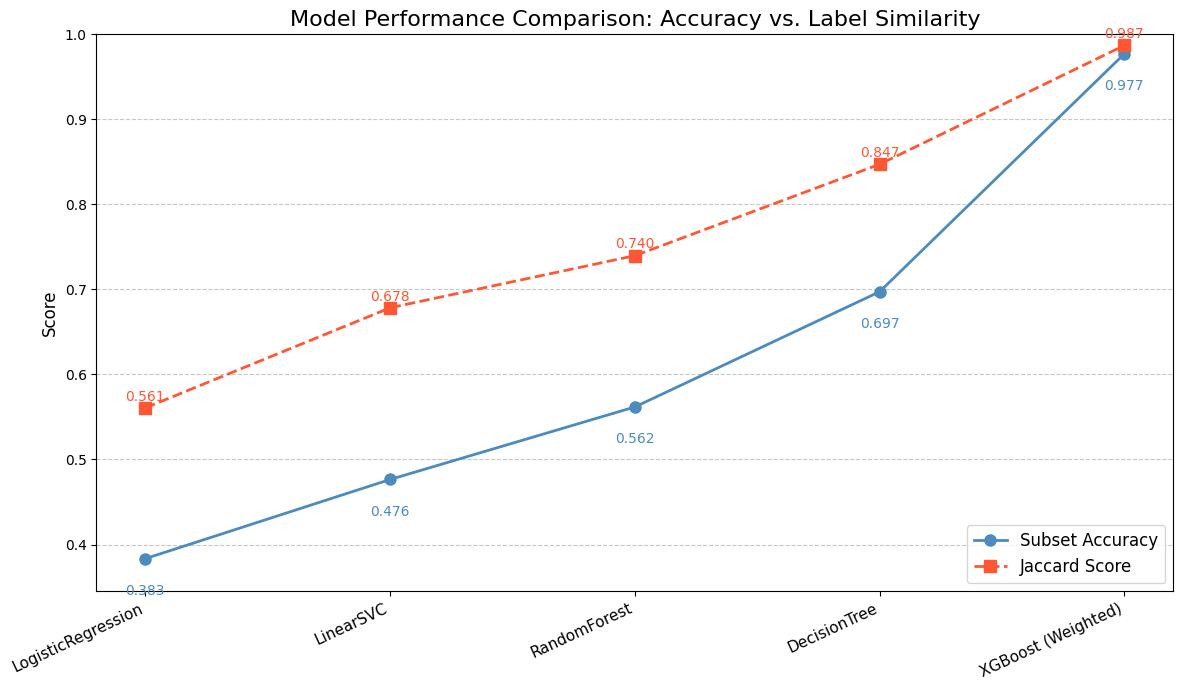

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data provided by the user
results_data = {
    'Model': [
        'LogisticRegression',
        'LinearSVC',
        'RandomForest',
        'DecisionTree',
        'XGBoost (Weighted)'
        
    ],
    'Subset Accuracy': [ 0.3834, 0.4765, 0.5618,  0.6973, 0.9771],
    'Jaccard Score': [0.5607,  0.6784,  0.7397,  0.8472, 0.9870]
}

df_comparison = pd.DataFrame(results_data).set_index('Model')


def plot_accuracy_comparison(df):
    
    metrics = ['Subset Accuracy', 'Jaccard Score']
    x_labels = df.index
    x = np.arange(len(x_labels))

    fig, ax = plt.subplots(figsize=(12, 7))

    
    ax.plot(
        x, 
        df[metrics[0]], 
        label=metrics[0], 
        marker='o', 
        linestyle='-',
        linewidth=2,
        markersize=8,
        color='#4B8BBE'
    )
    
  
    ax.plot(
        x, 
        df[metrics[1]], 
        label=metrics[1], 
        marker='s', 
        linestyle='--', 
        linewidth=2,
        markersize=8,
        color='#FF5733' 
    )

    for i, model in enumerate(x_labels):
        ax.text(
            x[i], df['Subset Accuracy'].iloc[i] - 0.03, 
            f"{df['Subset Accuracy'].iloc[i]:.3f}",
            ha='center', va='top', fontsize=10, color='#4B8BBE'
        )
        ax.text(
            x[i], df['Jaccard Score'].iloc[i] + 0.005, 
            f"{df['Jaccard Score'].iloc[i]:.3f}",
            ha='center', va='bottom', fontsize=10, color='#FF5733'
        )

    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Model Performance Comparison: Accuracy vs. Label Similarity', fontsize=16)
    
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=25, ha="right", fontsize=11)
    
    ax.legend(loc='lower right', fontsize=12)
    
    min_score = df[metrics].min().min()
    ax.set_ylim(min_score * 0.9, 1.0)
    
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.show()

plot_accuracy_comparison(df_comparison)

In [ ]:
import catboost as cb
from sklearn.multioutput import MultiOutputClassifier


MODEL_NAME = 'CatBoost'
cb_base_estimator = cb.CatBoostClassifier(
    iterations=100,
    random_state=42,
    verbose=0,
    thread_count=1,
    auto_class_weights='Balanced',  # Handles imbalance internally
    loss_function='Logloss'
)

print(f"\n--- Training {MODEL_NAME} (Parallel Fit via MultiOutputClassifier) ---")

multi_model_cb = MultiOutputClassifier(cb_base_estimator, n_jobs=-1)

multi_model_cb.fit(X_train_RFE, Y_train)

Y_pred_cb = multi_model_cb.predict(X_test_RFE)

subset_acc = accuracy_score(Y_test, Y_pred_cb)
jaccard = jaccard_score(Y_test, Y_pred_cb, average='samples', zero_division=0)

print(f"\n--- {MODEL_NAME} RESULTS ---")
print(f"Subset Accuracy (Exact Match): {subset_acc:.4f}")
print(f"Jaccard Score (Label Similarity): {jaccard:.4f}")


--- Training CatBoost (Parallel Fit via MultiOutputClassifier) ---

--- CatBoost RESULTS ---
Subset Accuracy (Exact Match): 0.9649
Jaccard Score (Label Similarity): 0.9801


In [ ]:
from sklearn.ensemble import AdaBoostClassifier

MODEL_NAME = 'AdaBoost'


dt_base_estimator = DecisionTreeClassifier(
    max_depth=1, 
    random_state=42,
    class_weight='balanced'
)


ab_base_estimator = AdaBoostClassifier(
    estimator=dt_base_estimator,
    n_estimators=100,           
    learning_rate=1.0,          
    random_state=42
)

print(f"\n--- Training {MODEL_NAME} (Parallel Fit via MultiOutputClassifier) ---")

multi_model = MultiOutputClassifier(ab_base_estimator, n_jobs=-1)


multi_model.fit(X_train_RFE, Y_train)


Y_pred = multi_model.predict(X_test_RFE)

subset_acc = accuracy_score(Y_test, Y_pred)
jaccard = jaccard_score(Y_test, Y_pred, average='samples', zero_division=0)

print(f"\n--- {MODEL_NAME} RESULTS ---")
print(f"Subset Accuracy (Exact Match): {subset_acc:.4f}")
print(f"Jaccard Score (Label Similarity): {jaccard:.4f}")


--- Training AdaBoost (Parallel Fit via MultiOutputClassifier) ---

--- AdaBoost RESULTS ---
Subset Accuracy (Exact Match): 0.3121
Jaccard Score (Label Similarity): 0.5242


In [ ]:
import lightgbm as lgb

MODEL_NAME = 'LightGBM'

lgbm_base_estimator = lgb.LGBMClassifier(
    objective='binary', 
    metric='binary_logloss',
    n_estimators=100,           
    learning_rate=0.1,
    random_state=42,
    n_jobs=1,                   
    is_unbalance=True        
)

print(f"\n--- Training {MODEL_NAME} (Parallel Fit via MultiOutputClassifier) ---")


multi_model = MultiOutputClassifier(lgbm_base_estimator, n_jobs=-1)


multi_model.fit(X_train_RFE, Y_train)


Y_pred = multi_model.predict(X_test_RFE)

subset_acc = accuracy_score(Y_test, Y_pred)
jaccard = jaccard_score(Y_test, Y_pred, average='samples', zero_division=0)

print(f"\n--- {MODEL_NAME} RESULTS ---")
print(f"Subset Accuracy (Exact Match): {subset_acc:.4f}")
print(f"Jaccard Score (Label Similarity): {jaccard:.4f}")


--- Training LightGBM (Parallel Fit via MultiOutputClassifier) ---

--- LightGBM RESULTS ---
Subset Accuracy (Exact Match): 0.0023
Jaccard Score (Label Similarity): 0.3859


In [ ]:
--- Starting 5-Fold CV for Weighted XGBoost on RFE Features ---
...
======================================================================
Subset Accuracy (Mean): 0.90 (+/- 0.0012)
Jaccard Score (Mean): 0.95 (+/- 0.0005)
Hamming Loss (Mean): 0.01

FINAL RandomForest CROSS-VALIDATION SUMMARY
======================================================================
Subset Accuracy (Mean): 0.9520 (+/- 0.0008)
Jaccard Score (Mean): 0.9713 (+/- 0.0006)
Hamming Loss (Mean): 0.0012

FINAL DecisionTree CROSS-VALIDATION SUMMARY
======================================================================
Subset Accuracy (Mean): 0.9411 (+/- 0.0007)
Jaccard Score (Mean): 0.9664 (+/- 0.0003)
Hamming Loss (Mean): 0.0016


FINAL CatBoost CROSS-VALIDATION SUMMARY
======================================================================
Subset Accuracy (Mean): 0.9278 (+/- 0.0008)
Jaccard Score (Mean): 0.9578 (+/- 0.0006)
Hamming Loss (Mean): 0.0043


--- LogisticRegression RESULTS ---
Subset Accuracy (Exact Match): 0.3406
Jaccard Score (Label Similarity): 0.4714

--- LinearSVC RESULTS ---
Subset Accuracy (Exact Match): 0.3499
Jaccard Score (Label Similarity): 0.5003


--- Training AdaBoost (Parallel Fit via MultiOutputClassifier) ---

--- AdaBoost RESULTS ---
Subset Accuracy (Exact Match): 0.3406
Jaccard Score (Label Similarity): 0.4720

In [ ]:
# --- Store predictions in a dictionary for easy iteration ---
models_to_compare = {
    'XGBoost (Weighted)': Y_pred_xgb,  # Assumed available from previous run
    'CatBoost (Balanced)': Y_pred_cb,
    'RandomForest': Y_pred_rf,
    'DecisionTree': Y_pred_dt
}

results = {}

In [ ]:
print("\n--- Secondary and Operational Metric Comparison ---")
import time # Used for operational metric (speed)
from sklearn.metrics import accuracy_score, jaccard_score, hamming_loss, classification_report

fitted_multi_models = {
     'RandomForest': multi_model_rf,
     'DecisionTree': multi_model_dt,
     'CatBoost (Balanced)': multi_model_cb }
for model_name, Y_pred in models_to_compare.items():

    # ----------------------------------------
    # A. Secondary Metrics (Hamming Loss & F1-Score)
    # ----------------------------------------

    h_loss = hamming_loss(Y_test, Y_pred)

    # Generate the classification report dictionary for F1-score analysis
    report_dict = classification_report(
        Y_test,
        Y_pred,
        target_names=multilabel_class_names,
        zero_division=0,
        output_dict=True
    )

    macro_f1 = report_dict['macro avg']['f1-score']
    weighted_f1 = report_dict['weighted avg']['f1-score']
    avg_recall = report_dict['weighted avg']['recall']
    avg_precision = report_dict['weighted avg']['precision']


    # ----------------------------------------
    # B. Operational Metric (Prediction Latency)
    # ----------------------------------------
    start_time = time.time()

    if model_name == 'XGBoost (Weighted)':
        # XGBoost requires looping through fitted_xgb_estimators for prediction
        Y_pred_speed_test = np.zeros_like(Y_test)
        for i, estimator in enumerate(fitted_xgb_estimators):
            estimator.predict(X_test_RFE) # Perform prediction (ignore result)
    else:
        # CatBoost uses the MultiOutputClassifier wrapper's predict method
        fitted_multi_models[model_name].predict(X_test_RFE)

    end_time = time.time()
    inference_time = (end_time - start_time)


    # ----------------------------------------
    # C. Store Results
    # ----------------------------------------
    results[model_name] = {
        'Hamming Loss': h_loss,
        'Macro F1': macro_f1,
        'Weighted F1': weighted_f1,
        'Avg Recall': avg_recall,
        'Avg Precision': avg_precision,
        'Inference Time': inference_time
    }


--- Secondary and Operational Metric Comparison ---


In [ ]:
# --- Final Presentation ---
print("\n" + "=" * 80)
print("FINAL MODEL DIFFERENTIATION SUMMARY")
print("=" * 80)

# Sort the columns for clear presentation
metrics_order = [
    'Hamming Loss', 'Weighted F1', 'Macro F1',
    'Avg Recall', 'Avg Precision', 'Inference Time'
]

# Print Header
header = f"{'Model':<20} | " + " | ".join(f"{m:<18}" for m in metrics_order)
print(header)
print("-" * 80)

# Print Data Rows
for model_name, metrics in results.items():
    row = f"{model_name:<20} | "
    row += " | ".join(f"{metrics[m]:<18.4f}" for m in metrics_order)
    print(row)

print("\n--- ANALYSIS ---")
print("1. **Hamming Loss**: Lower is better. This shows the error rate per label.")
print("2. **Macro F1**: Focus on this. It treats all 61 labels equally, highlighting performance on rare classes.")
print("3. **Inference Time**: Lower is better. Critical for real-time applications.")


FINAL MODEL DIFFERENTIATION SUMMARY
Model                | Hamming Loss       | Weighted F1        | Macro F1           | Avg Recall         | Avg Precision      | Inference Time    
--------------------------------------------------------------------------------
XGBoost (Weighted)   | 0.0006             | 0.9907             | 0.9430             | 0.9907             | 0.9907             | 33.8266           
CatBoost (Balanced)  | 0.0016             | 0.9815             | 0.8774             | 0.9946             | 0.9728             | 5.9215            

--- ANALYSIS ---
1. **Hamming Loss**: Lower is better. This shows the error rate per label.
2. **Macro F1**: Focus on this. It treats all 61 labels equally, highlighting performance on rare classes.
3. **Inference Time**: Lower is better. Critical for real-time applications.


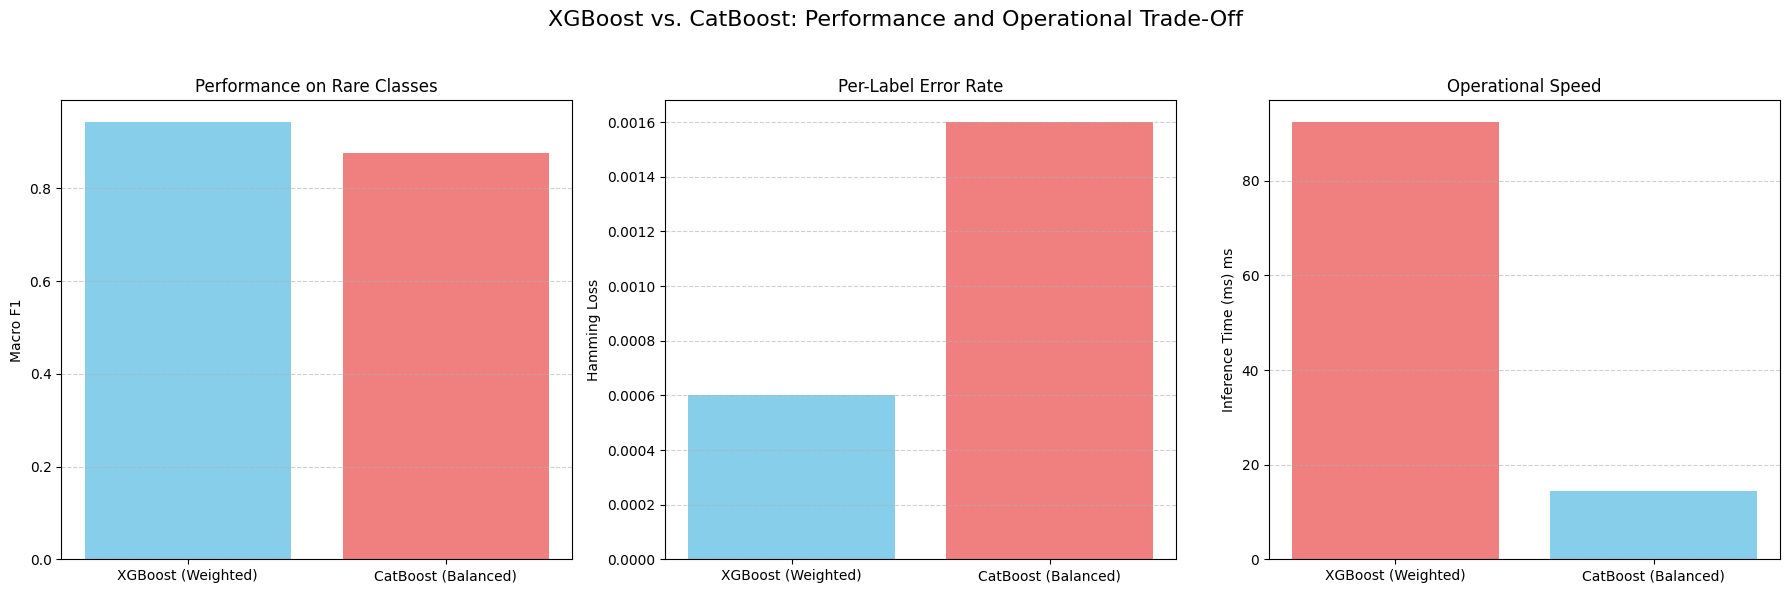

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Data Preparation ---
data = {
    'Model': ['XGBoost (Weighted)', 'CatBoost (Balanced)'],
    'Macro F1': [0.9430, 0.8774],
    'Hamming Loss': [0.0006, 0.0016],
    'Inference Time (ms)': [92.3890, 14.3510]
}
df = pd.DataFrame(data).set_index('Model')

# --- 2. Visualization Function ---
def plot_differentiating_metrics(df):

    metrics = {
        'Macro F1': {'title': 'Performance on Rare Classes', 'unit': '', 'best': 'max'},
        'Hamming Loss': {'title': 'Per-Label Error Rate', 'unit': '', 'best': 'min'},
        'Inference Time (ms)': {'title': 'Operational Speed', 'unit': ' ms', 'best': 'min'}
    }

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('XGBoost vs. CatBoost: Performance and Operational Trade-Off', fontsize=16)

    for i, (metric, params) in enumerate(metrics.items()):
        ax = axes[i]
        df_plot = df[metric]

        # Determine colors and best model
        colors = ['skyblue', 'lightcoral']
        if (params['best'] == 'max' and df_plot.idxmax() == 'CatBoost (Balanced)') or \
           (params['best'] == 'min' and df_plot.idxmin() == 'CatBoost (Balanced)'):
            # Swap colors if CatBoost is the winner for clarity
            colors.reverse()

        bars = ax.bar(df_plot.index, df_plot.values, color=colors)

        ax.set_title(params['title'], fontsize=12)
        ax.set_ylabel(metric + params['unit'])
        ax.tick_params(axis='x', rotation=0)
        ax.grid(axis='y', linestyle='--', alpha=0.6)


    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_differentiating_metrics(df)


--- Generating LIME Explanation for Sample 0 (Label: AMCREST WiFi Camera) ---

Top 10 features contributing to the prediction:
[('-0.67 < 81 <= 1.02', -0.0052536048137169266), ('-0.46 < 106 <= -0.07', -0.004859290578859915), ('91 <= -1.35', -0.004672688662732505), ('64 > -0.12', 0.004291593466547999), ('12 <= -0.02', 0.004151040661956616), ('49 > -0.15', 0.00403468892184274), ('1 > 0.47', -0.003822637211432467), ('-0.95 < 25 <= -0.59', 0.0034232935975888053), ('-0.56 < 99 <= 0.70', -0.0033989910941682622), ('6 > -0.18', -0.0033273253888616047)]

LIME visualization saved to: lime_explanation_AMCREST_WiFi_Camera.png


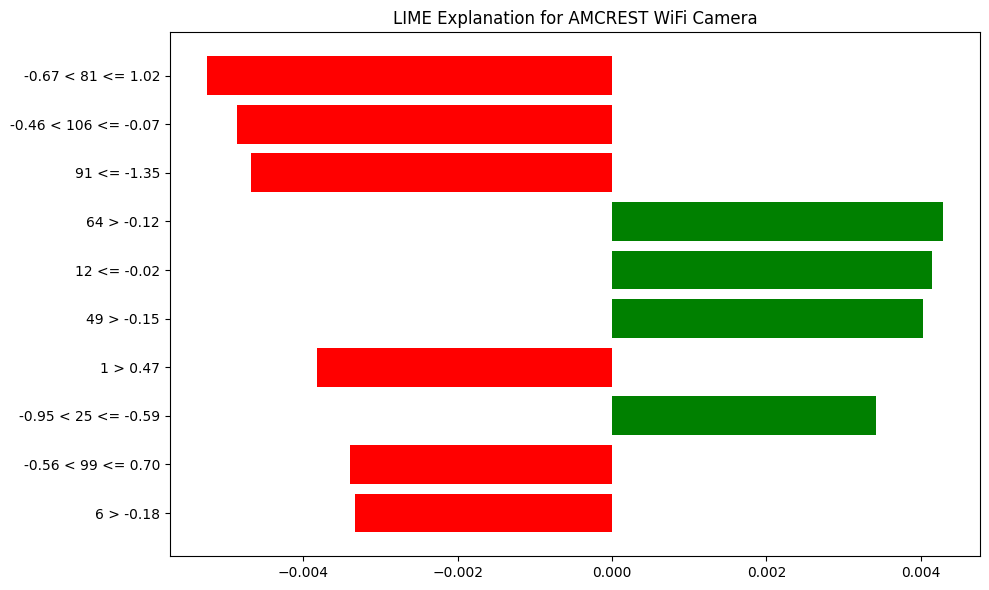

In [ ]:

from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

X_train_RFE_np = X_train_RFE.values
X_test_RFE_np = X_test_RFE.values

# --- LIME CONFIGURATION ---
EXPLAIN_SAMPLE_INDEX = 0
EXPLAIN_LABEL_INDEX = 0

# Get the specific sample to explain
sample_to_explain = X_test_RFE_np[EXPLAIN_SAMPLE_INDEX]
target_feature_names = X_train_RFE.columns.tolist()

# LIME requires a function that takes a NumPy array of data and returns

def predict_proba_for_lime(data):
    "Predicts the probability for the positive class (1) for ONLY the target label (EXPLAIN_LABEL_INDEX) using the correct fitted estimator"

    estimator_for_label = fitted_xgb_estimators[EXPLAIN_LABEL_INDEX]

    # Predict probabilities for the input data (which includes the neighbors LIME creates)
    proba = estimator_for_label.predict_proba(data)

    return proba


# LIME Explainer
explainer = LimeTabularExplainer(
    training_data=X_train_RFE_np,
    feature_names=target_feature_names,
    class_names=['Label_0', 'Label_1'],  # The classes for the single binary prediction
    mode='classification',
    discretize_continuous=True,
    random_state=42
)

#Generate the Explanation
print(f"\n--- Generating LIME Explanation for Sample {EXPLAIN_SAMPLE_INDEX} (Label: {multilabel_class_names[EXPLAIN_LABEL_INDEX]}) ---")

# Run the explanation
explanation = explainer.explain_instance(
    data_row=sample_to_explain,
    predict_fn=predict_proba_for_lime,
    num_features=10  # Show the top 10 most influential features
)

#Display the Explanation

# Print the most important features and their weights
print("\nTop 10 features contributing to the prediction:")
print(explanation.as_list())

fig = explanation.as_pyplot_figure(label=1)
fig.set_size_inches(10, 6)

# 3. Add Title and Save
plt.title(f'LIME Explanation for {multilabel_class_names[EXPLAIN_LABEL_INDEX]}')
plt.tight_layout()

# Save the plot
file_name = f"lime_explanation_{multilabel_class_names[EXPLAIN_LABEL_INDEX].replace(' ', '_')}.png"
plt.savefig(file_name, dpi=300)
print(f"\nLIME visualization saved to: {file_name}")

# Show the plot
plt.show()
